In [8]:
-0# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

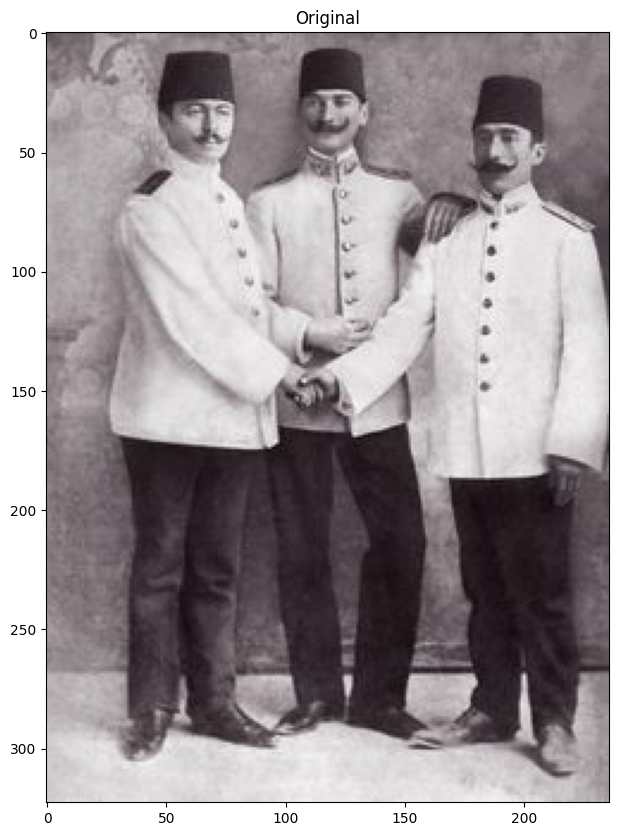

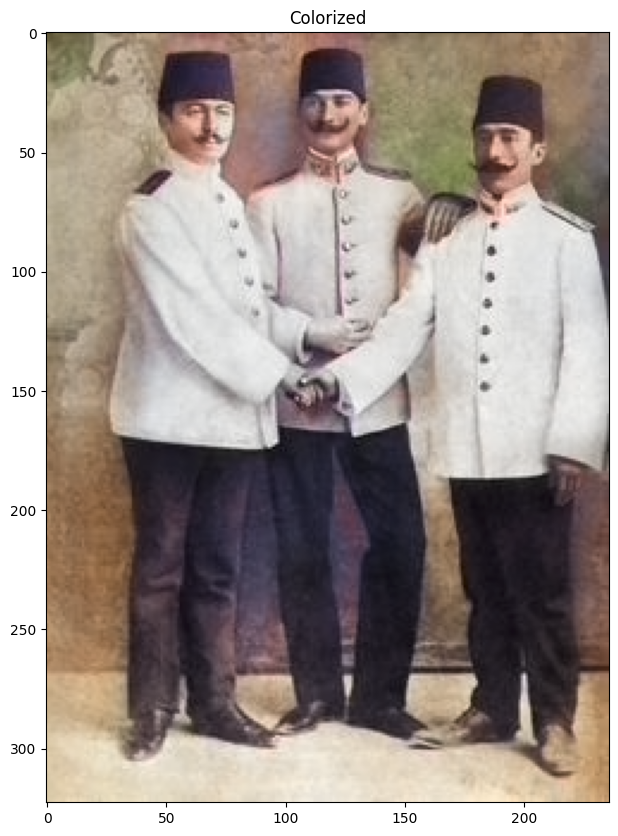

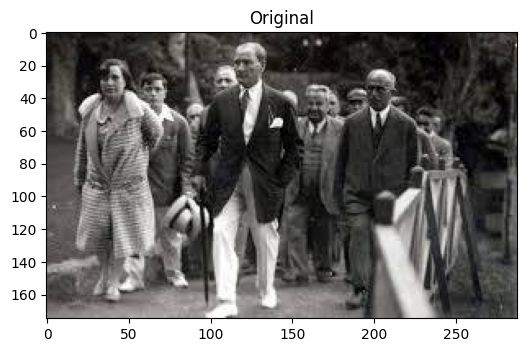

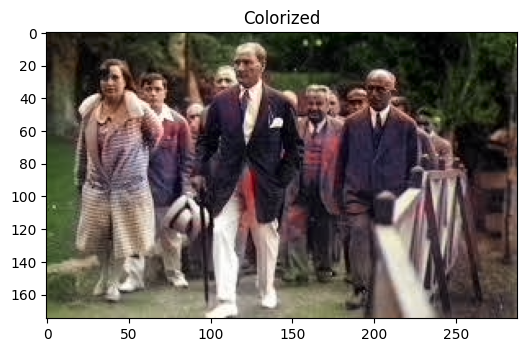

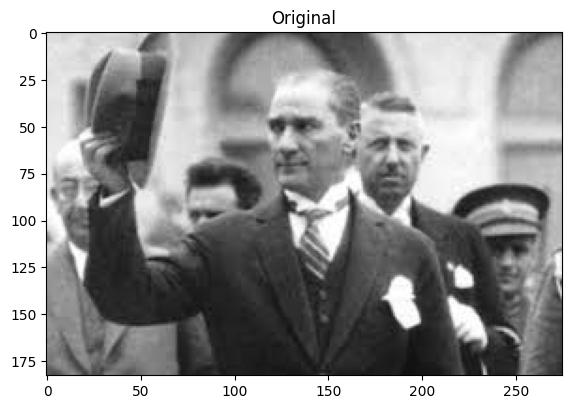

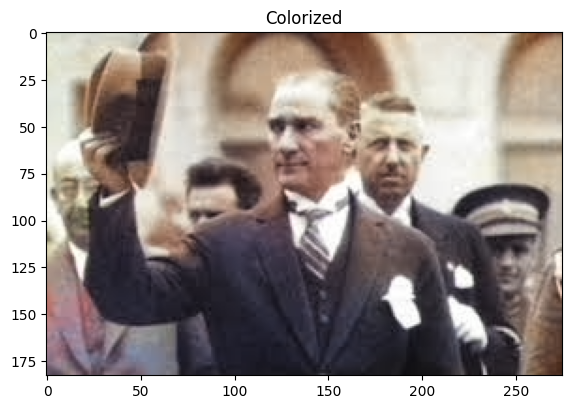

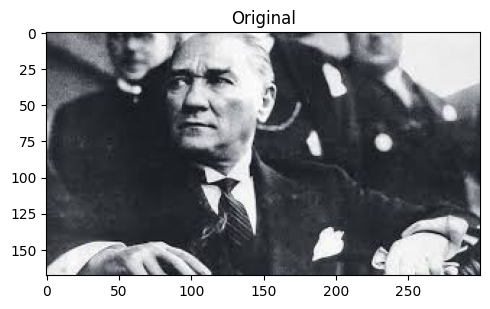

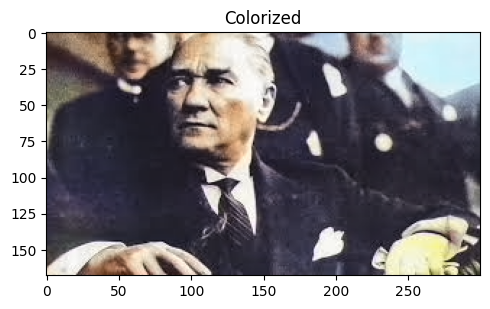

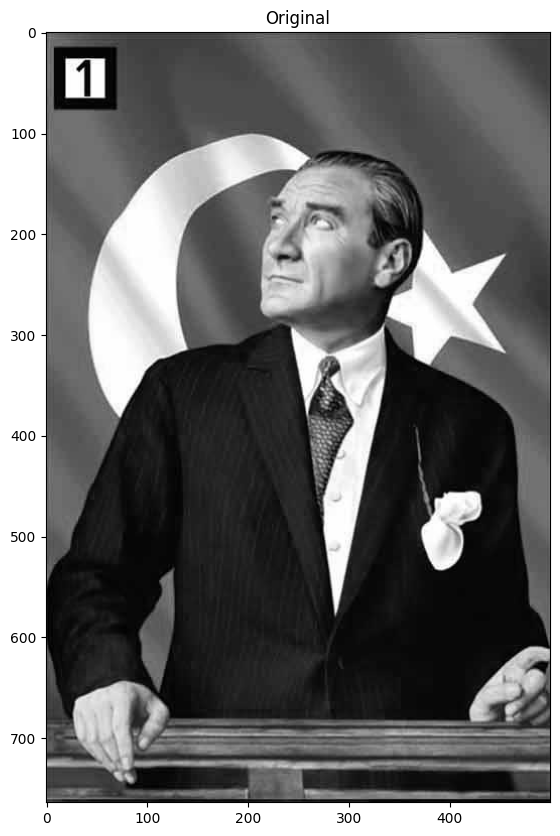

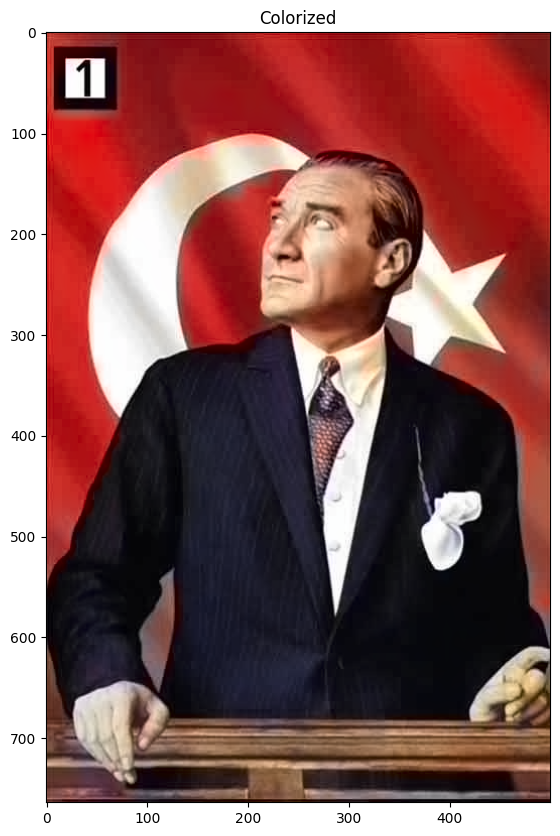

In [9]:
import os 
# Get our images
file_path = r"C:\Users\cengh\Desktop\dataset\colorize\blackandwhite\\"
blackandwhite_imgs = [f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]
kernel = r"C:\Users\cengh\Desktop\dataset\colorize\pts_in_hull.npy"

# Start the main program
if __name__ == '__main__':

    # Select desired model
    net = cv2.dnn.readNetFromCaffe(r"C:\Users\cengh\Desktop\dataset\colorize\colorization_deploy_v2.prototxt",
                                   r"C:\Users\cengh\Desktop\dataset\colorize\colorization_release_v2.caffemodel")

    # Load cluster centers
    pts_in_hull = np.load(kernel)

    # Populate cluster centers as 1x1 convolution kernel
    pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1)
    net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull.astype(np.float32)]
    net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

    for image in blackandwhite_imgs:
        img = cv2.imread(os.path.join(file_path, image))

        img_rgb = (img[:, :, [2, 1, 0]] * 1.0 / 255).astype(np.float32)
        img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)

        # Pull out L channel
        img_l = img_lab[:, :, 0]

        # Get original image size
        (H_orig, W_orig) = img_rgb.shape[:2]

        # Resize image to network input size
        img_rs = cv2.resize(img_rgb, (224, 224))

        # Resize image to network input size
        img_lab_rs = cv2.cvtColor(img_rs, cv2.COLOR_RGB2LAB)
        img_l_rs = img_lab_rs[:, :, 0]

        # Subtract 50 for mean-centering
        img_l_rs -= 50

        net.setInput(cv2.dnn.blobFromImage(img_l_rs))

        # This is our result
        ab_dec = net.forward('class8_ab')[0, :, :, :].transpose((1, 2, 0))

        (H_out, W_out) = ab_dec.shape[:2]
        ab_dec_us = cv2.resize(ab_dec, (W_orig, H_orig))
        img_lab_out = np.concatenate((img_l[:, :, np.newaxis], ab_dec_us), axis=2)

        # Concatenate with original image L
        img_bgr_out = np.clip(cv2.cvtColor(img_lab_out, cv2.COLOR_LAB2BGR), 0, 1)

        # Show original image
        imshow('Original', img)
        
        # Resize the colorized image to its original dimensions
        img_bgr_out = cv2.resize(img_bgr_out, (W_orig, H_orig), interpolation=cv2.INTER_AREA)
        imshow('Colorized', (img_bgr_out * 255).astype(np.uint8))